<a href="https://colab.research.google.com/github/hfoffani/HF-fastai/blob/main/nb21_iula_blurr_highapi_esp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq transformers tqdm
!pip install -Uqq ohmeow-blurr

     |████████████████████████████████| 2.6 MB 7.4 MB/s 
     |████████████████████████████████| 76 kB 6.4 MB/s 
     |████████████████████████████████| 3.3 MB 58.7 MB/s 
     |████████████████████████████████| 895 kB 61.2 MB/s 
     |████████████████████████████████| 636 kB 65.2 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 188 kB 13.4 MB/s 
     |████████████████████████████████| 1.2 MB 14.6 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 264 kB 38.8 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 243 kB 41.0 MB/s 
     |████████████████████████████████| 118 kB 52.9 MB/s 


In [2]:
import os
import glob
import pandas as pd

from blurr.modeling.core import BlearnerForSequenceClassification

from fastai.text.all import *

### Leer Corpus

In [3]:
co_df = pd.read_csv('/content/drive/MyDrive/iula-es.csv')
num_labels = co_df['label'].nunique()
co_df

,label,sentence,is_valid
0,economía,LOS POSTULADOS DE LA ECONOMÍA CLÁSICA,True
1,economía,"La mayor parte de los tratados sobre la teoría del valor y de la producción se refieren, en primer término, a la distribución de un volumen dado de recursos empleados en diferentes usos, y a las condiciones que, supuesta la ocupación de esta cantidad de recursos, determinen su remuneración relativa y el relativo valor de sus productos [1]",False
2,economía,"También se ha sujetado con frecuencia a un procedimiento descriptivo lo relativo al monto de los recursos disponibles (entendiendo por tales el volumen de población susceptible de tomar empleo), los límites de la riqueza natural y el equipo de producción acumulado; pero rara vez se ha examinado detenidamente en la teoría pura, la explicación de lo que determina la ocupación real de los recursos disponibles.",False
3,economía,"Decir que no se ha considerado en absoluto, seria absurdo, por supuesto; porque todo estudio sobre los altibajos de la ocupación, que han sido muchos, ha tenido que ver con el tema.",False
4,economía,"No quiero decir que se haya pasado por alto, sino que la teoría fundamental en que descansa se ha creído tan sencilla y evidente que casi no había para qué mencionarla [2]",False
...,...,...,...
52350,medicina,Diarrea.,True
52351,medicina,Debilidad.,False
52352,medicina,Gusto alterado.,False
52353,medicina,Parestesias peribucales.,False


### Modelar

In [4]:

# pretained models
#   "distilbert-base-uncased"
#   "bert-base-uncased"
#   "nlptown/bert-base-multilingual-uncased-sentiment"
#   "distilroberta-base"
pretrained_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

In [5]:
dl_kwargs = {'bs': 4, 'val_bs': 8}
learn_kwargs = { 'metrics': [F1Score(average=None)] }

learn = BlearnerForSequenceClassification.from_dataframe(
    co_df, pretrained_model_name, 
    text_attr='sentence', label_attr='label',
    dblock_splitter=ColSplitter(),
    dl_kwargs=dl_kwargs, learner_kwargs=learn_kwargs)

learn = learn.to_fp16()


Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [6]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 228 x 768       
Embedding                                 81315072   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

### Entrenar

SuggestedLRs(valley=0.00363078061491251)

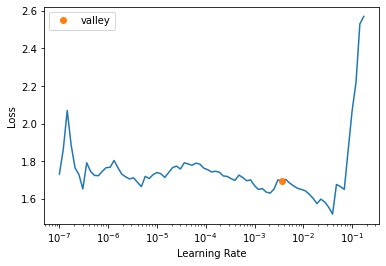

In [7]:
learn.lr_find()

In [84]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,f1_score,time
0,0.376686,0.243654,[0.80241692 0.81591119 0.8042328 0.94261767 0.91955914],07:58
1,0.238745,0.218839,[0.83116883 0.84348218 0.85714286 0.94814952 0.92530513],07:55
2,0.201821,0.206297,[0.83901855 0.8552381 0.87567568 0.94982779 0.92968124],07:55


In [85]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"quedan reservadas, en todo caso, a las fuerzas y cuerpos de seguridad del estado bajo la dependencia del gobierno los servicios policiales de caracter extracomunitario y supracomunitario como la vigilancia de puertos, aeropuertos, costas y fronteras, aduanas, control de entrada y salida del territorio nacional de espanoles y extranjeros, regimen general de extranjeria, extradicion y expulsion, emigracion e inmigracion, pasaportes, documento nacional de identidad, trafico, armas y explosivos, resguardo fiscal del estado, contrabando y fraude fiscal y las demas funciones que directamente les encomienda el articulo 104 de la constitucion [ 19 ] y las que les atribuya la ley organica que lo desarrolle.",legal,legal
1,"pero es evidente que ambos desarrollos estaban llamados a reforzarse reciprocamente y que, por un lado, los metodos, los materiales y los resultados de la investigacion del ciclo economico incluian cada vez mas economia general, mientras, por otro, los metodos, los materiales y los resultados de la moderna macrodinamica se desarrollaron principalmente para servir a la investigacion del ciclo economico, [ 13 ] hasta el punto de que la referencia a este tema irrumpe incluso en los titulos de muchas publicaciones macrodinamicas de alcance mucho mas amplio. [ 14 ]",economía,economía
2,"en una situacion dada de la tecnica, los gustos y las condiciones sociales que determinan la distribucion del ingreso, el ingreso real de una persona subira y bajara con la cantidad de unidades de trabajo de que puede disponer, es decir, con el monto de su ingreso medio en unidades de salario ; aunque, cuando el volumen total de produccion cambia, su ingreso real subira menos que proporcionalmente a su ingreso medido en unidades de salario ( debido a la influencia de los rendimientos decrecientes ).",economía,economía
3,"la preparacion del factor viii no es solo un proceso muy caro, dada su baja concentracion inicial en un fluido cuya disponibilidad es limitada y que ya es de por si valioso, sino que, como cada preparacion se obtiene a partir de la sangre de muchos miles de donantes, hay un riesgo importante de que con las inyecciones del factor de coagulacion se puedan transmitir a los hemofilicos virus peligrosos, como el de la hepatitis o el del sida.",medicina,medicina
4,"considerando que la decision... /... / ce ( cuarto programa marco ) justifica la realizacion de una accion comunitaria si, entre otras cosas, la investigacion contribuye a aumentar la cohesion economica y social de la comunidad, favorece el desarrollo global armonioso en su seno y cumple, al mismo tiempo, con el objetivo de calidad cientifica y tecnica ; que el presente programa pretende contribuir a la consecucion de tales objetivos.",medicina,medicina


### Evaluar

In [86]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'f1_score': array([0.83901855, 0.8552381 , 0.87567568, 0.94982779, 0.92968124]),
 'loss': 0.2062966525554657}

In [87]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([10471, 5]) torch.Size([10471]) torch.Size([10471])
TensorBase(0.20630) TensorBase(0.92484)


### Infererir

In [88]:
learn.export('iula_learner.pkl')

In [89]:
inf_learn = load_learner('iula_learner.pkl')

In [90]:
predictions = inf_learn.blurr_predict(pd.DataFrame([
    {'sentence': 'Según el BCE la inflación en el próximo año será menor al 2%'},
    {'sentence': 'La cardiopatía congénita es tratable vía transplante'},
    {'sentence': 'Mala calidad del aire durante la calima'},
    {'sentence': 'Las partículas de 2,5 micras pueden producir disminución de la función pulmonar'},
]))

In [91]:
for p in predictions:
  probs = p[2][0].numpy().tolist()
  print(f"{p[0][0]}\t", ("   {:.6f}"*len(probs)).format(*probs))

economía	    0.006473   0.992926   0.000009   0.000242   0.000350
medicina	    0.000078   0.000127   0.000004   0.999481   0.000310
ambiente	    0.394824   0.157732   0.001748   0.325381   0.120315
medicina	    0.000679   0.000044   0.000006   0.998550   0.000721
